# 🧹⚙️ Nettoyage Avancé pour le NLP Français

## 📋 Objectifs de ce Notebook

Dans ce notebook, nous allons aller au-delà du nettoyage basique et créer une **classe personnalisée** pour le nettoyage avancé de textes français.

### 🎯 Ce que vous allez apprendre :
- ✅ Créer une classe `NettoyeurFrancais` réutilisable
- ✅ Gérer les accents et la normalisation Unicode
- ✅ Implémenter des stratégies configurables pour les emojis
- ✅ Comparer les performances des différentes approches
- ✅ Tester sur des exemples réels du web français

### ⏱️ Durée estimée : 45-60 minutes

---

## 📦 Imports et Configuration

Commençons par importer tous les modules nécessaires :

In [8]:
!pip install seaborn
!pip install --upgrade pip

import re
import unicodedata
import time
from typing import List, Dict, Optional
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Configuration pour les graphiques
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Imports terminés !")
print("📚 Prêt pour le nettoyage avancé !")


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
  Using cached pip-25.1.1-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-25.1.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0
✅ Imports terminés !
📚 Prêt pour le nettoyage avancé !


## 🤔 Problèmes du Nettoyage Basique

Avant de créer notre solution avancée, voyons pourquoi le nettoyage basique ne suffit pas toujours :

In [10]:
# Exemples de textes "problématiques" du web français
textes_problematiques = [
    "J'ADORE ce café ☕😍 à Montréal !!! C'est GÉNIAL 🤩",
    "Rendez-vous à 14h30 contact@email.fr #super",
    "N'hésitez PAS !!! Visitez https://site.com 👍",
    "Très    bon    produit    ⭐⭐⭐⭐⭐ recommandé",
    "État: NEUF | Prix: 50€ | Livraison: GRATUITE!!!",
    "Café/thé/chocolat... tout est délicieux 😋🍰"
]

def nettoyage_basique(texte):
    """Nettoyage basique comme vu précédemment"""
    # Minuscules
    texte = texte.lower()
    # Suppression ponctuation
    texte = re.sub(r'[^\w\s]', ' ', texte)
    # Normalisation espaces
    texte = re.sub(r'\s+', ' ', texte).strip()
    return texte

print("🔍 Analyse des problèmes du nettoyage basique :\n")

for i, texte in enumerate(textes_problematiques, 1):
    original = texte
    nettoye = nettoyage_basique(texte)
    
    print(f"📝 Exemple {i}:")
    print(f"   Original : {original}")
    print(f"   Nettoyé  : {nettoye}")
    
    # Identification des problèmes
    problemes = []
    if 'http' in original.lower() and 'http' in nettoye:
        problemes.append("🌐 URLs pas supprimées")
    if '@' in original and '@' not in nettoye:
        problemes.append("📧 Emails cassés")
    if any(c in original for c in '😍😋🤩☕👍⭐🍰') and len(nettoye) < len(original) * 0.7:
        problemes.append("😊 Emojis perdus (info sentiment)")
    if 'café' in original.lower() and 'cafe' in nettoye:
        problemes.append("🔡 Accents perdus")
    
    if problemes:
        print(f"   ⚠️ Problèmes: {', '.join(problemes)}")
    else:
        print(f"   ✅ Nettoyage correct")
    print()

🔍 Analyse des problèmes du nettoyage basique :

📝 Exemple 1:
   Original : J'ADORE ce café ☕😍 à Montréal !!! C'est GÉNIAL 🤩
   Nettoyé  : j adore ce café à montréal c est génial
   ✅ Nettoyage correct

📝 Exemple 2:
   Original : Rendez-vous à 14h30 contact@email.fr #super
   Nettoyé  : rendez vous à 14h30 contact email fr super
   ⚠️ Problèmes: 📧 Emails cassés

📝 Exemple 3:
   Original : N'hésitez PAS !!! Visitez https://site.com 👍
   Nettoyé  : n hésitez pas visitez https site com
   ⚠️ Problèmes: 🌐 URLs pas supprimées

📝 Exemple 4:
   Original : Très    bon    produit    ⭐⭐⭐⭐⭐ recommandé
   Nettoyé  : très bon produit recommandé
   ⚠️ Problèmes: 😊 Emojis perdus (info sentiment)

📝 Exemple 5:
   Original : État: NEUF | Prix: 50€ | Livraison: GRATUITE!!!
   Nettoyé  : état neuf prix 50 livraison gratuite
   ✅ Nettoyage correct

📝 Exemple 6:
   Original : Café/thé/chocolat... tout est délicieux 😋🍰
   Nettoyé  : café thé chocolat tout est délicieux
   ✅ Nettoyage correct



## 🏗️ Classe NettoyeurFrancais Avancée

Créons maintenant une classe personnalisée qui résout ces problèmes :

In [11]:
class NettoyeurFrancais:
    """
    Classe avancée pour le nettoyage de textes français.
    
    Fonctionnalités :
    - Gestion intelligente des accents
    - Stratégies configurables pour les emojis
    - Suppression intelligente des URLs/emails
    - Normalisation Unicode complète
    - Optimisé pour le français
    """
    
    def __init__(self, 
                 garder_accents: bool = True,
                 strategie_emojis: str = 'supprimer',  # 'supprimer', 'convertir', 'garder'
                 supprimer_urls: bool = True,
                 supprimer_emails: bool = True,
                 supprimer_mentions: bool = True,
                 supprimer_hashtags: bool = True):
        """
        Initialise le nettoyeur avec les options choisies.
        
        Args:
            garder_accents: Si True, préserve les accents français
            strategie_emojis: 'supprimer', 'convertir' ou 'garder'
            supprimer_urls: Si True, supprime les URLs
            supprimer_emails: Si True, supprime les emails
            supprimer_mentions: Si True, supprime les @mentions
            supprimer_hashtags: Si True, supprime les #hashtags
        """
        self.garder_accents = garder_accents
        self.strategie_emojis = strategie_emojis
        self.supprimer_urls = supprimer_urls
        self.supprimer_emails = supprimer_emails
        self.supprimer_mentions = supprimer_mentions
        self.supprimer_hashtags = supprimer_hashtags
        
        # Dictionnaire pour convertir les emojis en mots
        self.emoji_vers_mots = {
            '😀': ' très content ',
            '😍': ' adore ',
            '🤩': ' fantastique ',
            '😋': ' délicieux ',
            '😊': ' content ',
            '🙂': ' bien ',
            '😐': ' moyen ',
            '😕': ' pas content ',
            '😞': ' triste ',
            '😡': ' en colère ',
            '👍': ' bien ',
            '👎': ' pas bien ',
            '❤️': ' amour ',
            '💔': ' déçu ',
            '⭐': ' excellent ',
            '☕': ' café ',
            '🍰': ' gâteau ',
            '🎉': ' super ',
            '💯': ' parfait ',
            '🔥': ' génial '
        }
        
        # Patterns regex précompilés pour les performances
        self.pattern_url = re.compile(r'https?://[^\s]+|www\.[^\s]+', re.IGNORECASE)
        self.pattern_email = re.compile(r'\S+@\S+\.\S+')
        self.pattern_mention = re.compile(r'@\w+')
        self.pattern_hashtag = re.compile(r'#\w+')
        self.pattern_espaces = re.compile(r'\s+')
        
    def normaliser_unicode(self, texte: str) -> str:
        """
        Normalise le texte Unicode (gère les caractères composés).
        """
        # Normalisation NFD puis recomposition
        texte = unicodedata.normalize('NFD', texte)
        
        if not self.garder_accents:
            # Supprime les accents (diacritiques)
            texte = ''.join(c for c in texte if unicodedata.category(c) != 'Mn')
        
        # Recomposition
        texte = unicodedata.normalize('NFC', texte)
        return texte
    
    def traiter_emojis(self, texte: str) -> str:
        """
        Traite les emojis selon la stratégie choisie.
        """
        if self.strategie_emojis == 'supprimer':
            # Supprime tous les emojis
            emoji_pattern = re.compile(
                "["
                "\U0001F600-\U0001F64F"  # emoticons
                "\U0001F300-\U0001F5FF"  # symbols & pictographs
                "\U0001F680-\U0001F6FF"  # transport & map
                "\U0001F1E0-\U0001F1FF"  # flags
                "\U00002600-\U000026FF"  # miscellaneous symbols
                "\U00002700-\U000027BF"  # dingbats
                "]+", re.UNICODE)
            texte = emoji_pattern.sub(' ', texte)
            
        elif self.strategie_emojis == 'convertir':
            # Convertit les emojis connus en mots
            for emoji, mot in self.emoji_vers_mots.items():
                texte = texte.replace(emoji, mot)
            
            # Supprime les emojis restants
            emoji_pattern = re.compile(
                "["
                "\U0001F600-\U0001F64F"
                "\U0001F300-\U0001F5FF"
                "\U0001F680-\U0001F6FF"
                "\U0001F1E0-\U0001F1FF"
                "\U00002600-\U000026FF"
                "\U00002700-\U000027BF"
                "]+", re.UNICODE)
            texte = emoji_pattern.sub(' ', texte)
        
        # Si 'garder', on ne fait rien
        return texte
    
    def supprimer_elements_web(self, texte: str) -> str:
        """
        Supprime les éléments web (URLs, emails, mentions, hashtags).
        """
        if self.supprimer_urls:
            texte = self.pattern_url.sub(' ', texte)
        
        if self.supprimer_emails:
            texte = self.pattern_email.sub(' ', texte)
        
        if self.supprimer_mentions:
            texte = self.pattern_mention.sub(' ', texte)
        
        if self.supprimer_hashtags:
            texte = self.pattern_hashtag.sub(' ', texte)
        
        return texte
    
    def nettoyer(self, texte: str) -> str:
        """
        Nettoie un texte selon les paramètres configurés.
        
        Args:
            texte: Le texte à nettoyer
            
        Returns:
            Le texte nettoyé
        """
        if not isinstance(texte, str):
            return ""
        
        # Étape 1: Normalisation Unicode
        texte = self.normaliser_unicode(texte)
        
        # Étape 2: Traitement des emojis
        texte = self.traiter_emojis(texte)
        
        # Étape 3: Suppression des éléments web
        texte = self.supprimer_elements_web(texte)
        
        # Étape 4: Conversion en minuscules
        texte = texte.lower()
        
        # Étape 5: Suppression de la ponctuation (garde les accents si demandé)
        if self.garder_accents:
            # Garde les lettres accentuées françaises
            texte = re.sub(r'[^\w\sàâäéèêëïîôöùûüÿç]', ' ', texte)
        else:
            texte = re.sub(r'[^\w\s]', ' ', texte)
        
        # Étape 6: Normalisation des espaces
        texte = self.pattern_espaces.sub(' ', texte).strip()
        
        return texte
    
    def nettoyer_batch(self, textes: List[str]) -> List[str]:
        """
        Nettoie une liste de textes.
        """
        return [self.nettoyer(texte) for texte in textes]
    
    def obtenir_config(self) -> Dict:
        """
        Retourne la configuration actuelle.
        """
        return {
            'garder_accents': self.garder_accents,
            'strategie_emojis': self.strategie_emojis,
            'supprimer_urls': self.supprimer_urls,
            'supprimer_emails': self.supprimer_emails,
            'supprimer_mentions': self.supprimer_mentions,
            'supprimer_hashtags': self.supprimer_hashtags
        }

print("✅ Classe NettoyeurFrancais créée !")
print("🎯 Prêt pour les tests avancés !")

✅ Classe NettoyeurFrancais créée !
🎯 Prêt pour les tests avancés !


## 🧪 Test de la Classe avec Différentes Configurations

Testons notre classe avec différents paramètres pour voir les différences :

In [12]:
# Texte de test complexe
texte_test = "J'ADORE ce café ☕😍 à Montréal !!! C'est GÉNIAL 🤩 contact@test.fr https://site.com #super @marie"

print("🧪 Test de différentes configurations\n")
print(f"📝 Texte original : {texte_test}\n")

# Configuration 1: Préservation maximale
nettoyeur1 = NettoyeurFrancais(
    garder_accents=True,
    strategie_emojis='garder',
    supprimer_urls=False,
    supprimer_emails=False,
    supprimer_mentions=False,
    supprimer_hashtags=False
)

resultat1 = nettoyeur1.nettoyer(texte_test)
print("🔧 Config 1 - Préservation maximale:")
print(f"   Résultat: {resultat1}")
print(f"   Config: {nettoyeur1.obtenir_config()}\n")

# Configuration 2: Nettoyage standard
nettoyeur2 = NettoyeurFrancais(
    garder_accents=True,
    strategie_emojis='supprimer',
    supprimer_urls=True,
    supprimer_emails=True,
    supprimer_mentions=True,
    supprimer_hashtags=True
)

resultat2 = nettoyeur2.nettoyer(texte_test)
print("🔧 Config 2 - Nettoyage standard:")
print(f"   Résultat: {resultat2}")
print(f"   Config: {nettoyeur2.obtenir_config()}\n")

# Configuration 3: Conversion emojis + suppression accents
nettoyeur3 = NettoyeurFrancais(
    garder_accents=False,
    strategie_emojis='convertir',
    supprimer_urls=True,
    supprimer_emails=True,
    supprimer_mentions=True,
    supprimer_hashtags=True
)

resultat3 = nettoyeur3.nettoyer(texte_test)
print("🔧 Config 3 - Conversion emojis + suppression accents:")
print(f"   Résultat: {resultat3}")
print(f"   Config: {nettoyeur3.obtenir_config()}\n")

# Analyse des différences
print("📊 Analyse des différences:")
print(f"   Longueur originale: {len(texte_test)} caractères")
print(f"   Config 1: {len(resultat1)} caractères ({len(resultat1.split())} mots)")
print(f"   Config 2: {len(resultat2)} caractères ({len(resultat2.split())} mots)")
print(f"   Config 3: {len(resultat3)} caractères ({len(resultat3.split())} mots)")

print("\n💡 Observations:")
if 'à' in resultat2 and 'a' in resultat3:
    print("   • Les accents sont préservés dans config 2, supprimés dans config 3")
if len(resultat3.split()) > len(resultat2.split()):
    print("   • La conversion d'emojis ajoute des mots (config 3)")
if 'contact' not in resultat2 and 'contact' in texte_test:
    print("   • Les emails sont supprimés dans configs 2 et 3")

🧪 Test de différentes configurations

📝 Texte original : J'ADORE ce café ☕😍 à Montréal !!! C'est GÉNIAL 🤩 contact@test.fr https://site.com #super @marie

🔧 Config 1 - Préservation maximale:
   Résultat: j adore ce café à montréal c est génial contact test fr https site com super marie
   Config: {'garder_accents': True, 'strategie_emojis': 'garder', 'supprimer_urls': False, 'supprimer_emails': False, 'supprimer_mentions': False, 'supprimer_hashtags': False}

🔧 Config 2 - Nettoyage standard:
   Résultat: j adore ce café à montréal c est génial
   Config: {'garder_accents': True, 'strategie_emojis': 'supprimer', 'supprimer_urls': True, 'supprimer_emails': True, 'supprimer_mentions': True, 'supprimer_hashtags': True}

🔧 Config 3 - Conversion emojis + suppression accents:
   Résultat: j adore ce cafe café adore a montreal c est genial fantastique
   Config: {'garder_accents': False, 'strategie_emojis': 'convertir', 'supprimer_urls': True, 'supprimer_emails': True, 'supprimer_mentions': Tru

## 🎯 Comparaison avec Nettoyage Basique

Comparons notre classe avancée avec le nettoyage basique sur nos exemples problématiques :

In [14]:
# Utilisons le nettoyeur standard pour la comparaison
nettoyeur_avance = NettoyeurFrancais(
    garder_accents=True,
    strategie_emojis='convertir',
    supprimer_urls=True,
    supprimer_emails=True,
    supprimer_mentions=True,
    supprimer_hashtags=True
)

print("⚔️ Comparaison Nettoyage Basique vs Avancé\n")

# Créons un DataFrame pour une comparaison claire
comparaisons = []

for i, texte in enumerate(textes_problematiques, 1):
    basique = nettoyage_basique(texte)
    avance = nettoyeur_avance.nettoyer(texte)
    
    comparaisons.append({
        'Exemple': i,
        'Original': texte,
        'Basique': basique,
        'Avancé': avance,
        'Mots_Basique': len(basique.split()),
        'Mots_Avance': len(avance.split()),
        'Accents_Preserves': 'café' in avance if 'café' in texte else None,
        'URLs_Supprimees': 'http' not in avance if 'http' in texte else None
    })
    
    print(f"📝 Exemple {i}:")
    print(f"   Original : {texte}")
    print(f"   Basique  : {basique}")
    print(f"   Avancé   : {avance}")
    
    # Calcul des améliorations
    ameliorations = []
    if 'http' in texte and 'http' not in avance and 'http' in basique:
        ameliorations.append("🌐 URLs supprimées")
    if any(emoji in texte for emoji in ['😍', '☕', '👍']) and any(mot in avance for mot in ['adore', 'café', 'bien']):
        ameliorations.append("😊 Emojis convertis en sentiment")
    if '@' in texte and '@' not in avance:
        ameliorations.append("📧 Mentions supprimées")
    if '#' in texte and '#' not in avance:
        ameliorations.append("🏷️ Hashtags supprimés")
    if any(char in texte for char in 'àéèùç') and any(char in avance for char in 'àéèùç'):
        ameliorations.append("🔤 Accents préservés")
    
    if ameliorations:
        print(f"   ✅ Améliorations: {', '.join(ameliorations)}")
    
    print()

# Créons un DataFrame pour analyse
df_comparaison = pd.DataFrame(comparaisons)
print("📊 Statistiques de comparaison:")
print(f"   Réduction moyenne de mots (basique): {df_comparaison['Mots_Basique'].mean():.1f} mots")
print(f"   Réduction moyenne de mots (avancé): {df_comparaison['Mots_Avance'].mean():.1f} mots")
print(f"   Gain moyen en précision: {(df_comparaison['Mots_Avance'].mean() - df_comparaison['Mots_Basique'].mean()):.1f} mots")

⚔️ Comparaison Nettoyage Basique vs Avancé

📝 Exemple 1:
   Original : J'ADORE ce café ☕😍 à Montréal !!! C'est GÉNIAL 🤩
   Basique  : j adore ce café à montréal c est génial
   Avancé   : j adore ce café café adore à montréal c est génial fantastique
   ✅ Améliorations: 😊 Emojis convertis en sentiment, 🔤 Accents préservés

📝 Exemple 2:
   Original : Rendez-vous à 14h30 contact@email.fr #super
   Basique  : rendez vous à 14h30 contact email fr super
   Avancé   : rendez vous à 14h30
   ✅ Améliorations: 📧 Mentions supprimées, 🏷️ Hashtags supprimés, 🔤 Accents préservés

📝 Exemple 3:
   Original : N'hésitez PAS !!! Visitez https://site.com 👍
   Basique  : n hésitez pas visitez https site com
   Avancé   : n hésitez pas visitez bien
   ✅ Améliorations: 🌐 URLs supprimées, 😊 Emojis convertis en sentiment, 🔤 Accents préservés

📝 Exemple 4:
   Original : Très    bon    produit    ⭐⭐⭐⭐⭐ recommandé
   Basique  : très bon produit recommandé
   Avancé   : très bon produit excellent excellent excell

## ⚡ Tests de Performance

Comparons les performances entre les différentes approches :

In [15]:
import time
import random

# Génération d'un dataset de test plus important
def generer_textes_test(n=1000):
    """Génère n textes de test variés"""
    modeles = [
        "J'adore ce produit 😍 super qualité ! contact@shop.fr",
        "Service client EXCELLENT 👍 je recommande https://site.com",
        "Très déçu 😞 qualité pas au rendez-vous... #arnaque",
        "Bon rapport qualité/prix 🤔 livraison rapide @vendeur",
        "PARFAIT !!! Exactement ce que je cherchais ⭐⭐⭐⭐⭐",
        "Moyen... ça peut aller mais sans plus 😐 www.avis.com"
    ]
    
    textes = []
    for _ in range(n):
        # Choix aléatoire d'un modèle
        base = random.choice(modeles)
        # Ajout de variations
        if random.random() < 0.3:  # 30% de chance d'ajouter du bruit
            base += f" {random.choice(['!!!', '???', '...', '   '])}"
        textes.append(base)
    
    return textes

# Génération du dataset
textes_test = generer_textes_test(1000)
print(f"📊 Dataset généré: {len(textes_test)} textes")
print(f"📝 Exemple: {textes_test[0]}")

# Test de performance
def mesurer_performance(nom, fonction, textes, iterations=3):
    """Mesure le temps d'exécution d'une fonction"""
    temps_total = 0
    
    for i in range(iterations):
        start = time.time()
        resultats = fonction(textes)
        end = time.time()
        temps_total += (end - start)
    
    temps_moyen = temps_total / iterations
    vitesse = len(textes) / temps_moyen
    
    return {
        'nom': nom,
        'temps_moyen': temps_moyen,
        'textes_par_seconde': vitesse,
        'resultats': len(resultats)
    }

# Tests des différentes configurations
print("\n⚡ Tests de performance en cours...\n")

# 1. Nettoyage basique
perf_basique = mesurer_performance(
    "Nettoyage Basique",
    lambda textes: [nettoyage_basique(t) for t in textes],
    textes_test
)

# 2. Nettoyeur avancé - config performance
nettoyeur_perf = NettoyeurFrancais(
    garder_accents=True,
    strategie_emojis='supprimer',
    supprimer_urls=True,
    supprimer_emails=True,
    supprimer_mentions=True,
    supprimer_hashtags=True
)

perf_avance_simple = mesurer_performance(
    "Avancé Simple",
    nettoyeur_perf.nettoyer_batch,
    textes_test
)

# 3. Nettoyeur avancé - config complète
nettoyeur_complet = NettoyeurFrancais(
    garder_accents=True,
    strategie_emojis='convertir',
    supprimer_urls=True,
    supprimer_emails=True,
    supprimer_mentions=True,
    supprimer_hashtags=True
)

perf_avance_complet = mesurer_performance(
    "Avancé Complet",
    nettoyeur_complet.nettoyer_batch,
    textes_test
)

# Affichage des résultats
performances = [perf_basique, perf_avance_simple, perf_avance_complet]

print("📊 Résultats de performance:")
print("=" * 60)
for perf in performances:
    print(f"{perf['nom']:20} | {perf['temps_moyen']:6.3f}s | {perf['textes_par_seconde']:8.0f} textes/s")

print("\n💡 Analyse:")
base_vitesse = perf_basique['textes_par_seconde']
for perf in performances[1:]:
    ratio = perf['textes_par_seconde'] / base_vitesse
    if ratio > 0.8:
        print(f"   ✅ {perf['nom']}: {ratio:.1f}x par rapport au basique (acceptable)")
    elif ratio > 0.5:
        print(f"   ⚠️ {perf['nom']}: {ratio:.1f}x par rapport au basique (plus lent mais acceptable)")
    else:
        print(f"   ❌ {perf['nom']}: {ratio:.1f}x par rapport au basique (trop lent)")

📊 Dataset généré: 1000 textes
📝 Exemple: Très déçu 😞 qualité pas au rendez-vous... #arnaque

⚡ Tests de performance en cours...

📊 Résultats de performance:
Nettoyage Basique    |  0.005s |   219123 textes/s
Avancé Simple        |  0.008s |   119930 textes/s
Avancé Complet       |  0.009s |   114069 textes/s

💡 Analyse:
   ⚠️ Avancé Simple: 0.5x par rapport au basique (plus lent mais acceptable)
   ⚠️ Avancé Complet: 0.5x par rapport au basique (plus lent mais acceptable)


## 📈 Visualisation des Résultats

Créons des graphiques pour mieux comprendre les améliorations :

/var/folders/h5/v_y9zhbd59718s68xdcrdwl40000gn/T/ipykernel_82428/2967804946.py:31: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/h5/v_y9zhbd59718s68xdcrdwl40000gn/T/ipykernel_82428/2967804946.py:31: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/guillaume/.pyenv/versions/3.13.0/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/guillaume/.pyenv/versions/3.13.0/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


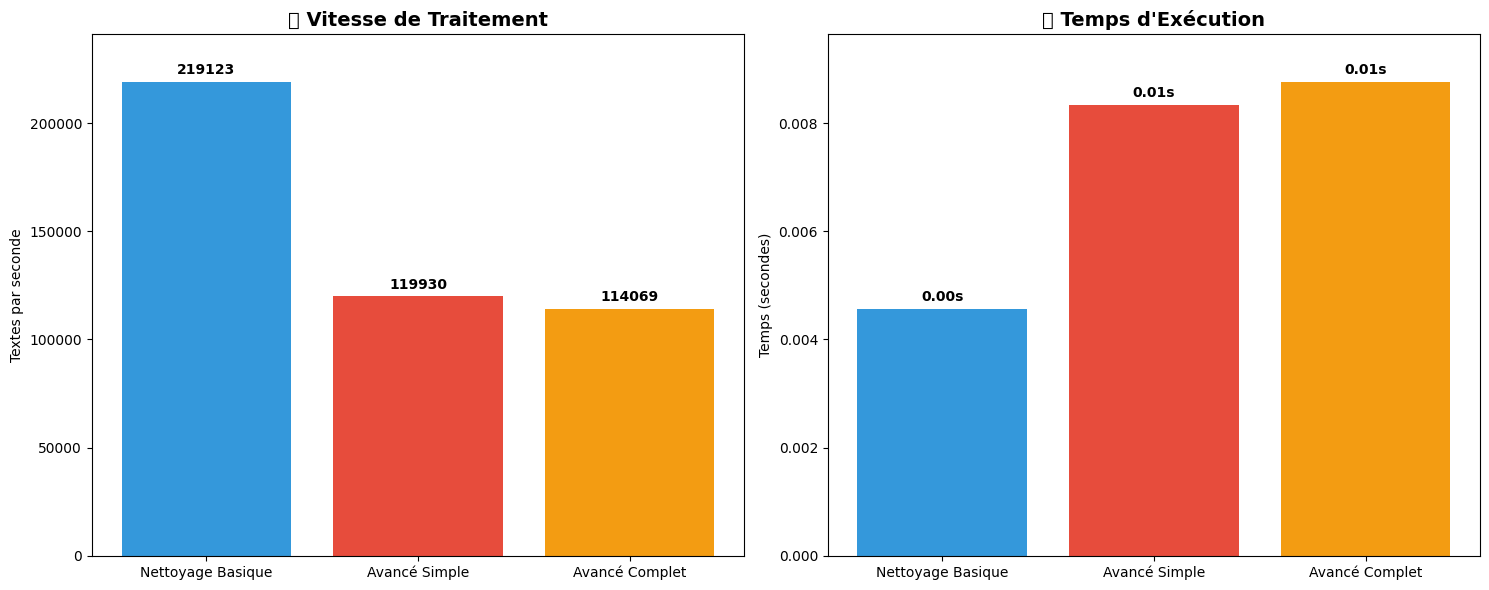


🔍 Analyse qualitative sur échantillon:

📝 Exemple 1:
   Original: Très déçu 😞 qualité pas au rendez-vous... #arnaque
   Basique:  très déçu qualité pas au rendez vous arnaque
   Avancé:   très déçu triste qualité pas au rendez vous
   ⚖️ Même nombre de mots (8)

📝 Exemple 2:
   Original: Service client EXCELLENT 👍 je recommande https://site.com ???
   Basique:  service client excellent je recommande https site com
   Avancé:   service client excellent bien je recommande
   🔍 Basique conserve plus de mots (8 vs 6)

📝 Exemple 3:
   Original: Moyen... ça peut aller mais sans plus 😐 www.avis.com
   Basique:  moyen ça peut aller mais sans plus www avis com
   Avancé:   moyen ça peut aller mais sans plus moyen
   🔍 Basique conserve plus de mots (10 vs 8)

📝 Exemple 4:
   Original: Très déçu 😞 qualité pas au rendez-vous... #arnaque
   Basique:  très déçu qualité pas au rendez vous arnaque
   Avancé:   très déçu triste qualité pas au rendez vous
   ⚖️ Même nombre de mots (8)

📝 Exemple 5:
   

In [16]:
# Préparation des données pour la visualisation
methodes = [p['nom'] for p in performances]
vitesses = [p['textes_par_seconde'] for p in performances]
temps = [p['temps_moyen'] for p in performances]

# Graphique 1: Vitesse de traitement
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graphique des vitesses
bars1 = ax1.bar(methodes, vitesses, color=['#3498db', '#e74c3c', '#f39c12'])
ax1.set_title('🚀 Vitesse de Traitement', fontsize=14, fontweight='bold')
ax1.set_ylabel('Textes par seconde')
ax1.set_ylim(0, max(vitesses) * 1.1)

# Ajout des valeurs sur les barres
for bar, vitesse in zip(bars1, vitesses):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(vitesses)*0.01,
             f'{vitesse:.0f}', ha='center', va='bottom', fontweight='bold')

# Graphique des temps
bars2 = ax2.bar(methodes, temps, color=['#3498db', '#e74c3c', '#f39c12'])
ax2.set_title('⏱️ Temps d\'Exécution', fontsize=14, fontweight='bold')
ax2.set_ylabel('Temps (secondes)')
ax2.set_ylim(0, max(temps) * 1.1)

# Ajout des valeurs sur les barres
for bar, temp in zip(bars2, temps):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(temps)*0.01,
             f'{temp:.2f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Analyse de la qualité du nettoyage
print("\n🔍 Analyse qualitative sur échantillon:")

# Test sur quelques exemples pour la qualité
echantillon = textes_test[:5]
for i, texte in enumerate(echantillon, 1):
    basique = nettoyage_basique(texte)
    avance = nettoyeur_complet.nettoyer(texte)
    
    print(f"\n📝 Exemple {i}:")
    print(f"   Original: {texte}")
    print(f"   Basique:  {basique}")
    print(f"   Avancé:   {avance}")
    
    # Score qualitatif simple
    score_basique = len(basique.split())
    score_avance = len(avance.split())
    
    if score_avance > score_basique:
        print(f"   ✅ Avancé conserve plus d'informations ({score_avance} vs {score_basique} mots)")
    elif score_avance == score_basique:
        print(f"   ⚖️ Même nombre de mots ({score_avance})")
    else:
        print(f"   🔍 Basique conserve plus de mots ({score_basique} vs {score_avance})")

## 🎯 Cas d'Usage Pratiques

Voyons comment choisir la bonne configuration selon le contexte :

In [17]:
# Différents cas d'usage avec leurs configurations recommandées
cas_usage = {
    "Analyse de sentiment e-commerce": {
        "config": NettoyeurFrancais(
            garder_accents=True,
            strategie_emojis='convertir',  # Les emojis portent du sentiment
            supprimer_urls=True,
            supprimer_emails=True,
            supprimer_mentions=False,  # Les mentions peuvent être importantes
            supprimer_hashtags=False   # Les hashtags peuvent porter du sentiment
        ),
        "exemple": "Super produit 😍 merci @boutique ! #satisfait https://shop.com",
        "justification": "Garde les informations de sentiment (emojis→mots, mentions, hashtags)"
    },
    
    "Classification de documents": {
        "config": NettoyeurFrancais(
            garder_accents=True,
            strategie_emojis='supprimer',  # Focus sur le contenu textuel
            supprimer_urls=True,
            supprimer_emails=True,
            supprimer_mentions=True,
            supprimer_hashtags=True
        ),
        "exemple": "Article sur l'intelligence artificielle en France 🤖 par @expert",
        "justification": "Supprime le bruit, focus sur le contenu sémantique principal"
    },
    
    "Recherche d'information": {
        "config": NettoyeurFrancais(
            garder_accents=False,  # Facilite la recherche
            strategie_emojis='supprimer',
            supprimer_urls=True,
            supprimer_emails=True,
            supprimer_mentions=True,
            supprimer_hashtags=True
        ),
        "exemple": "Recherche d'hôtels à Montréal avec café inclus",
        "justification": "Supprime accents pour recherche robuste (hotel=hôtel)"
    },
    
    "Analyse conversationnelle": {
        "config": NettoyeurFrancais(
            garder_accents=True,
            strategie_emojis='convertir',
            supprimer_urls=False,   # Les URLs peuvent être partagées intentionnellement
            supprimer_emails=False,
            supprimer_mentions=False, # Important pour comprendre les interactions
            supprimer_hashtags=False
        ),
        "exemple": "Salut @paul ! As-tu vu ce lien ? https://news.com 😊 #discussion",
        "justification": "Préserve le contexte conversationnel et les interactions"
    }
}

print("🎯 Configurations recommandées par cas d'usage\n")

for nom_cas, infos in cas_usage.items():
    print(f"📋 {nom_cas}:")
    print(f"   📝 Exemple: {infos['exemple']}")
    
    # Test du nettoyage
    resultat = infos['config'].nettoyer(infos['exemple'])
    print(f"   🔧 Résultat: {resultat}")
    print(f"   💡 Justification: {infos['justification']}")
    print(f"   ⚙️ Config: {infos['config'].obtenir_config()}")
    print()

🎯 Configurations recommandées par cas d'usage

📋 Analyse de sentiment e-commerce:
   📝 Exemple: Super produit 😍 merci @boutique ! #satisfait https://shop.com
   🔧 Résultat: super produit adore merci boutique satisfait
   💡 Justification: Garde les informations de sentiment (emojis→mots, mentions, hashtags)
   ⚙️ Config: {'garder_accents': True, 'strategie_emojis': 'convertir', 'supprimer_urls': True, 'supprimer_emails': True, 'supprimer_mentions': False, 'supprimer_hashtags': False}

📋 Classification de documents:
   📝 Exemple: Article sur l'intelligence artificielle en France 🤖 par @expert
   🔧 Résultat: article sur l intelligence artificielle en france par
   💡 Justification: Supprime le bruit, focus sur le contenu sémantique principal
   ⚙️ Config: {'garder_accents': True, 'strategie_emojis': 'supprimer', 'supprimer_urls': True, 'supprimer_emails': True, 'supprimer_mentions': True, 'supprimer_hashtags': True}

📋 Recherche d'information:
   📝 Exemple: Recherche d'hôtels à Montréal av

## 🛠️ Exercice Pratique

À votre tour ! Créez et testez votre propre configuration :

In [18]:
# 🎯 EXERCICE: Créez votre nettoyeur personnalisé

# Scénario: Vous analysez des avis clients pour un site de voyages français
# Les avis contiennent souvent des emojis, des mentions d'hôtels, des hashtags de lieux

avis_voyages = [
    "Séjour FANTASTIQUE à l'hôtel 🏨😍 Paris magnifique ! #Paris2024 @hoteldeluxe",
    "Très déçu du service... 😞 contact@hotel.fr ne répond pas #arnaque",
    "Belle vue sur la Tour Eiffel 🗼 mais chambre bruyante 😕 Prix: 150€/nuit",
    "Personnel accueillant 😊 petit-déjeuner délicieux ☕🥐 je recommande !",
    "Réservation via https://booking.com facile mais wifi défaillant 📶❌"
]

print("🎯 EXERCICE: Configurez votre nettoyeur pour l'analyse d'avis voyages\n")

# TODO: Créez votre configuration personnalisée
# Réfléchissez à:
# - Voulez-vous garder les emojis (info sentiment) ou les convertir ?
# - Les mentions d'hôtels sont-elles importantes ?
# - Les hashtags de lieux apportent-ils de l'info ?
# - Les accents français sont-ils importants ?

mon_nettoyeur = NettoyeurFrancais(
    garder_accents=True,      # À vous de décider !
    strategie_emojis='convertir',  # 'supprimer', 'convertir', ou 'garder' ?
    supprimer_urls=True,          # True ou False ?
    supprimer_emails=True,        # True ou False ?
    supprimer_mentions=False,     # True ou False ?
    supprimer_hashtags=False      # True ou False ?
)

print("📝 Test de votre configuration:\n")

for i, avis in enumerate(avis_voyages, 1):
    original = avis
    nettoye = mon_nettoyeur.nettoyer(avis)
    
    print(f"Avis {i}:")
    print(f"   Original: {original}")
    print(f"   Nettoyé:  {nettoye}")
    print(f"   Mots:     {len(nettoye.split())} mots")
    print()

print("🤔 Questions pour évaluer votre choix:")
print("   1. Votre nettoyage conserve-t-il l'information de sentiment ?")
print("   2. Les noms d'hôtels/lieux sont-ils préservés quand c'est pertinent ?")
print("   3. Le résultat est-il lisible et exploitable pour l'analyse ?")
print("   4. Y a-t-il un bon équilibre entre nettoyage et préservation d'info ?")

# Affichage de votre configuration finale
print(f"\n⚙️ Votre configuration finale: {mon_nettoyeur.obtenir_config()}")

🎯 EXERCICE: Configurez votre nettoyeur pour l'analyse d'avis voyages

📝 Test de votre configuration:

Avis 1:
   Original: Séjour FANTASTIQUE à l'hôtel 🏨😍 Paris magnifique ! #Paris2024 @hoteldeluxe
   Nettoyé:  séjour fantastique à l hôtel adore paris magnifique paris2024 hoteldeluxe
   Mots:     10 mots

Avis 2:
   Original: Très déçu du service... 😞 contact@hotel.fr ne répond pas #arnaque
   Nettoyé:  très déçu du service triste ne répond pas arnaque
   Mots:     9 mots

Avis 3:
   Original: Belle vue sur la Tour Eiffel 🗼 mais chambre bruyante 😕 Prix: 150€/nuit
   Nettoyé:  belle vue sur la tour eiffel mais chambre bruyante pas content prix 150 nuit
   Mots:     14 mots

Avis 4:
   Original: Personnel accueillant 😊 petit-déjeuner délicieux ☕🥐 je recommande !
   Nettoyé:  personnel accueillant content petit déjeuner délicieux café je recommande
   Mots:     9 mots

Avis 5:
   Original: Réservation via https://booking.com facile mais wifi défaillant 📶❌
   Nettoyé:  réservation via faci

## 📊 Récapitulatif et Bonnes Pratiques

Synthèse de ce que nous avons appris :

In [ ]:
print("📊 RÉCAPITULATIF DU NETTOYAGE AVANCÉ")
print("=" * 50)

print("\n✅ POINTS CLÉS APPRIS:")
print("   🏗️ Créer une classe réutilisable et configurable")
print("   🔤 Gérer intelligemment les accents français")
print("   😊 Traiter les emojis selon le contexte (supprimer/convertir/garder)")
print("   🌐 Nettoyer les éléments web (URLs, emails, mentions, hashtags)")
print("   ⚡ Optimiser les performances avec des regex précompilées")
print("   🎯 Adapter la configuration au cas d'usage")

print("\n💡 BONNES PRATIQUES:")
print("   1. 🧪 Toujours tester sur des exemples représentatifs")
print("   2. ⚖️ Équilibrer nettoyage et préservation d'information")
print("   3. 📏 Mesurer l'impact sur les performances")
print("   4. 🎯 Adapter la configuration au domaine d'application")
print("   5. 📝 Documenter et justifier ses choix techniques")
print("   6. 🔄 Rendre le code réutilisable et modulaire")

print("\n⚠️ PIÈGES À ÉVITER:")
print("   ❌ Sur-nettoyer et perdre de l'information cruciale")
print("   ❌ Ignorer les spécificités de la langue française")
print("   ❌ Utiliser la même config pour tous les cas d'usage")
print("   ❌ Ne pas tester les performances sur de gros volumes")
print("   ❌ Oublier de valider qualitativement les résultats")

print("\n🎯 RECOMMANDATIONS PAR CAS D'USAGE:")
print("   📈 Analyse sentiment: Convertir emojis, garder mentions/hashtags")
print("   📚 Classification: Supprimer le bruit, focus contenu")
print("   🔍 Recherche: Supprimer accents pour robustesse")
print("   💬 Conversation: Préserver le contexte interactionnel")

print("\n🚀 PROCHAINES ÉTAPES:")
print("   1. Maîtriser la tokenisation (découpage en mots)")
print("   2. Gérer les stopwords intelligemment")
print("   3. Implémenter la lemmatisation pour le français")
print("   4. Construire un pipeline complet et optimisé")

print("\n" + "=" * 50)
print("🎉 Félicitations ! Vous maîtrisez maintenant le nettoyage avancé !")
print("📖 Passez au notebook suivant: tokenisation_comparaison.ipynb")

## 💾 Sauvegarde de votre Classe

Pour réutiliser votre classe dans d'autres projets :

In [ ]:
# Optionnel: Sauvegarde de la classe dans un fichier Python
code_classe = '''
# nettoyeur_francais.py
# Classe personnalisée pour le nettoyage avancé de textes français

import re
import unicodedata
from typing import List, Dict

class NettoyeurFrancais:
    """Classe avancée pour le nettoyage de textes français"""
    
    def __init__(self, garder_accents=True, strategie_emojis='supprimer', **kwargs):
        # Votre code ici...
        pass
    
    def nettoyer(self, texte):
        # Votre code ici...
        pass
'''

print("💾 Code template pour réutilisation:")
print("\n📁 Créez un fichier 'nettoyeur_francais.py' avec le code de la classe")
print("📥 Puis importez avec: from nettoyeur_francais import NettoyeurFrancais")
print("🔧 Adaptez les paramètres selon vos besoins spécifiques")

print("\n✅ Notebook terminé avec succès !")
print("🎯 Vous êtes maintenant prêt(e) pour la tokenisation avancée !")